# New York & San Francisco Evleri Veri Seti

Bu çalışmada New York ve San Francisco'daki ev özellikleri hakkında küçük bir veri seti üzerinden çalışacağız. Bu veri setine **logistic regresyon** bağlamında inceleyeceğiz.

Bu dersin sonunda şunları yapabiliyor olmayı hedefliyoruz:

1. Evleri NY ve SF olarak sınıflandırmak (binary classification)
2. Logistic Regresyonun çalışma mantığını anlamak
3. Kullanılan algoritmaya göre featurelara scaling uygulamak
4. Tahmin sonuçlarının doğruluklarını irdelemek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

## 1. Veri Setini Yükleme ve İnceleme

Tabiki, ilk olarak çalışmamızda kullanacağımız veri setini çağırmamız gerekiyor :)

In [2]:
df_housing = pd.read_csv('ny_sf_apt.csv')
df_housing

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0
2,0,2.0,2.0,1350000,1900,2150,628,9
3,0,1.0,1.0,629000,1903,500,1258,9
4,0,0.0,1.0,439000,1930,500,878,10
...,...,...,...,...,...,...,...,...
487,1,5.0,2.5,1800000,1890,3073,586,76
488,1,2.0,1.0,695000,1923,1045,665,106
489,1,3.0,2.0,1650000,1922,1483,1113,106
490,1,1.0,1.0,649000,1983,850,764,163


Bu çalışmada hedefimiz, evin özelliklerini kullanarak **SF'da** mı yoksa **NY'da** mı olduğuna karar vermek. O zaman şimdi veri setimizi hazırlamaya başlayalım.

## 2. Eğitim ve Test için Veri Seti Bölümlemesi

![Train Test Spliting](https://i.stack.imgur.com/4fxtD.png)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_housing.iloc[:, 1:], df_housing.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42)

Veri setinin daha anlaşılır olması için küçük bir ekleme :)

In [4]:
train_df = X_train.copy()
train_df['in_sf'] = y_train

train_df['location'] = train_df['in_sf'].apply(lambda x: (x and 'SF') or 'NY')
train_df.head()

,beds,bath,price,year_built,sqft,price_per_sqft,elevation,in_sf,location
377,3.0,2.0,2395000,1929,2323,1031,73,1,SF
124,0.0,1.0,349000,1960,400,873,13,0,NY
419,4.0,3.0,3420000,1926,5113,669,98,1,SF
417,6.0,3.5,995000,2001,3080,323,55,1,SF
172,2.0,2.0,1599000,1973,1400,1142,10,0,NY


Şimdi de `pairplot()` fonksiyonundan yararlanarak evin **SF'da** veya **NY'da** olmasını etkileyen özellikleri inceleyelim ve **hangi özellikler daha ön plana çıkmış** onları kestirmeye çalışalım.

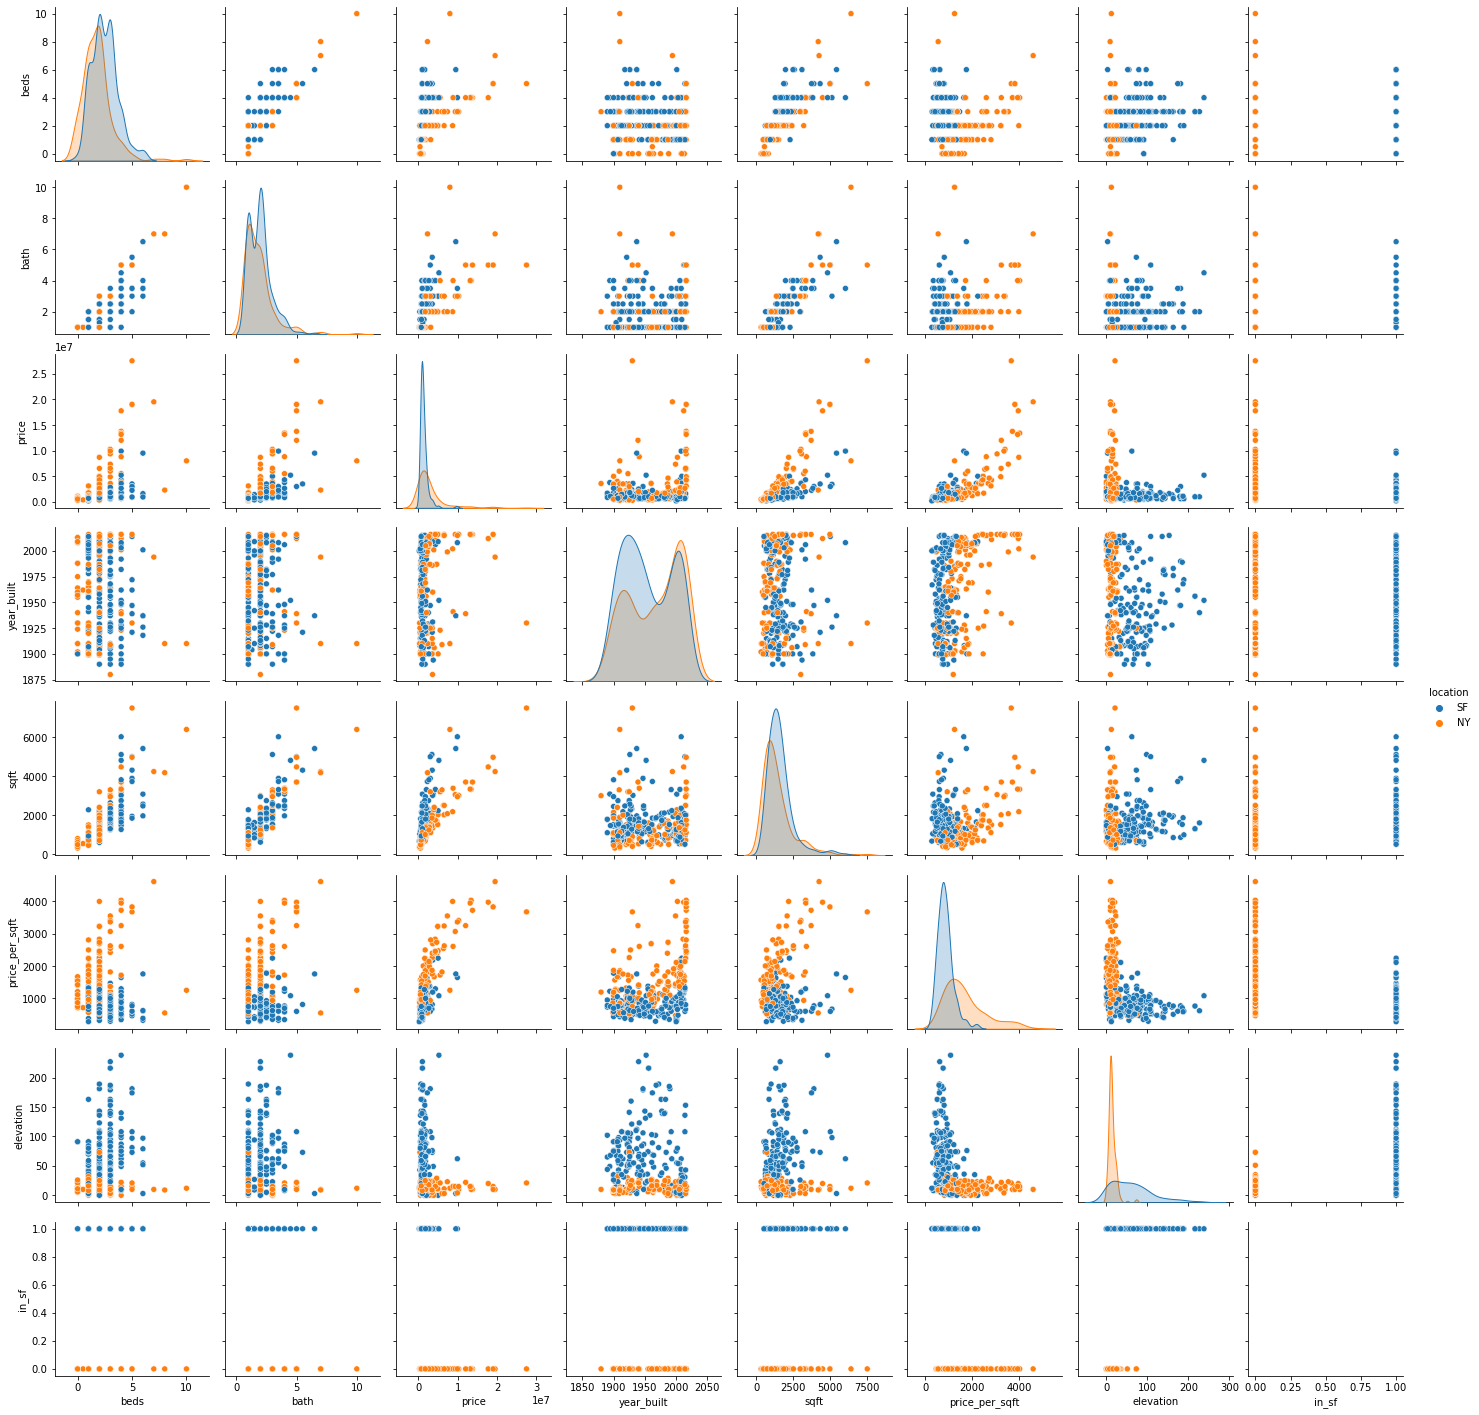

In [5]:
sns.pairplot(train_df, hue='location');

> **SORU:** Yaptığınız incelemeden sonra hangi featurelar evleri birbirinden daha kolay ayırt edebilmek için daha önemli gibi duruyor?

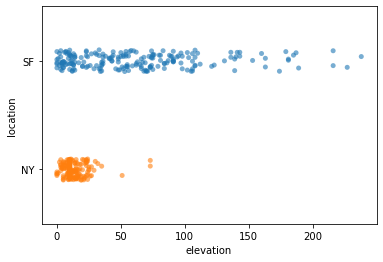

In [6]:
sns.stripplot(x='elevation', y='location', data=train_df, alpha=0.6);

Evet gerçekten de belli bir yükseklikten fazla olan evler **SF**'da gibi duruyor. Bunu modelimi inşa ederken kullanabilirim :)

## 3. Logistic Regresyon Modelimizi Oluşturma

Yaptığımız inceleme sonucunda **elevation(yükseklik)** oldukça önemli bir feature olarak gözükmüştü. Bu sebeple, ilk modelimizi oluştururken ilk aşamada sadece onu kullanarak bir model oluşturalım. Bakalım nasıl sonuçlarla karşılaşacağız?

> **NOT:** Sınıflandırma Problemlerine Giriş slaytımızda **Logistic Regresyon** gibi algoritmaları kullanırken, elimizdeki featurelara scaling uygulamamız gerektiğini konuşmuştuk. Ama şu anda **tek bir feature** ile model kuracağımız için bu işlem adımını ihtiyacımız yok.

In [7]:
lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train[['elevation']].values, y_train)

LogisticRegression(solver='liblinear')

In [8]:
print("Training Accuracy:", round(lm1.score(X_train[['elevation']].values, y_train), 3))
print("Testing Accuracy:", round(lm1.score(X_test[['elevation']].values, y_test), 3))

Training Accuracy: 0.796
Testing Accuracy: 0.808


Tek bir feature ile model oluşturmamıza rağmen fena olmayan bir başarı yakalamışız gibi duruyor. Bu tarz durumların oluşmasının sebebi bizim için **gerçekten önemli olan bir featurela** çalışmamızdır.

- O zaman hadi, modelimiz nasıl bir davranış sergilemiş ona daha yakından bakalım.

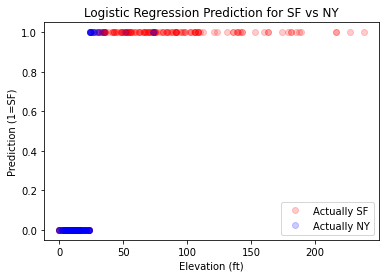

In [9]:
feature = train_df[['elevation']].values # Eğitimde kullandığım özellikler
prediction_train = lm1.predict(feature) # Bu özellikleri input olarak kullanarak tahmin gerçekleştirme

sf_mask = (train_df['location'] == 'SF')

plt.plot(feature[sf_mask], prediction_train[sf_mask], 'ro', label='Actually SF', alpha=0.2)
plt.plot(feature[~sf_mask], prediction_train[~sf_mask], 'bo', label='Actually NY', alpha=0.2)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prediction (1=SF)')
plt.title('Logistic Regression Prediction for SF vs NY')
plt.legend(loc='lower right');

Logistic Regresyon bizim için temelde **25 ft** civarında bir sınır değeri belirlemiş. Yani 25 ft'den daha alçakta olan evler için NY, 25 ft'den daha yüksekte olan evler için SF şeklinde tahminlerini gerçekleştirmiş.

In [10]:
lm1.predict([[25]])

array([1])

In [11]:
lm1.predict([[72],[8],[23]])

array([1, 0, 0])

Hatırlarsanız Logistic Regresyon, **Sigmoid Fonksiyonu** tabanlı çalışan bir algoritmaydı. Ve elimize yeni bir veri geldiğinde bunun Sigmoid Fonksiyonu'nda denk geldiği alana bakarak hangi sınıfta ait olmasının daha olası olduğunu inceliyorduk. Yani aslında tahmin sonucu olarak aynı sınıfa düşen 2 tane verinin, **o sınıfa ait olmalarının olasılığı birbiriyle eşit derecede olmayabilir**.

- Hadi gelin, bu şimdi de bu durumu inceleyelim.

In [12]:
lm1.predict_proba([[72],[8],[23]]) # Hatırlatma: in_sf(0) = NY, in_sf(1) = SF

array([[0.04085238, 0.95914762],
       [0.73953248, 0.26046752],
       [0.51480919, 0.48519081]])

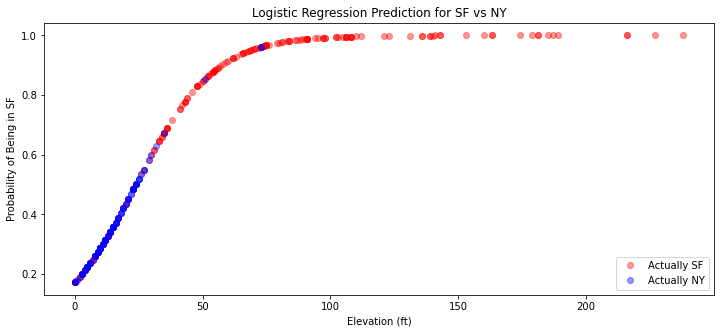

In [13]:
prediction_soft = lm1.predict_proba(feature)[:, 1]
plt.figure(figsize=[12,5])
plt.plot(feature[sf_mask], prediction_soft[sf_mask], 'ro', label='Actually SF',alpha=0.4)
plt.plot(feature[~sf_mask], prediction_soft[~sf_mask], 'bo', label='Actually NY',alpha=0.4)
plt.xlabel('Elevation (ft)')
plt.ylabel('Probability of Being in SF')
plt.title('Logistic Regression Prediction for SF vs NY')
plt.legend(loc='lower right');

Bu sefer elimizde sadece hangi elevation değerlerinin hangi sınıfa denk geldiği bilgisi yok. Hangi elevation değerlerinin, hangi sınıfta yer almaya daha yakın olduğu bilgisi(olasılık) var. 

Süper! Yapacağımız çalışmalarda cut-off değerini belirlemeye çalışırken bu durumunu da göz önünde bulundurabiliriz.

In [14]:
print(lm1.coef_, lm1.intercept_)
print('Cut-Off Value:', abs(lm1.intercept_ / lm1.coef_))

[[0.06561906]] [-1.56849255]
Cut-Off Value: [[23.90300112]]


In [15]:
lm1.predict_proba([[23.90300112]])

array([[0.5, 0.5]])

In [16]:
lm1.predict([[23.9]])

array([0])

Logistic Regresyon problemlerinden sınıfların olasılıklarına bakılırken, **%50 olasılığına** $\beta_1 x_1 + \beta_0  = 0$, denklemi sağlandığında ulaşılır. Dolasıyla elimizdeki değerlere göre bu problemi çözmeye çalıştığımızda,

$$0.06561906*elevation_{crit} - 1.56849255 = 0 \Rightarrow elevation_{crit} = \frac{1.56849255}{0.06561906} \approx 23.9$$

İşte burada bulduğumuz **23.9** değeri, Logistic Regresyon modelimizin %50 olasılık için belirlemiş olduğu cut-off değeri. Hatırlarsınız biz grafiğimizi incelerken bu değerin yaklaşık olarak 25 ft civarında olmasını gerektiğini öngörmüştük :)

## 4. Sınıflandırma Problemlerinde Model Değerlendirmesi

Şu ana kadar her şey güzel. Ancak hala büyük bir eksiğimiz var. `lm1.score()` fonksiyonun bize sağladığı değer ne anlama geliyordu? Bu aslında modelin genel doğruluğuna ilişkin bir ölçü. Ama sınıflandırma problemlerinde, amacımız doğrultusunda farklı doğruluk metriklerini değerlendirmeye ihtiyaç duyarız ve bu değerlerdirme yapabilmek için de `confusion_matrix`'den yararlanırız.

- O zaman şimdi biraz da, **confusion matrix(hata matrisi)** bize nasıl bilgiler sağlıyormuş onları inceleyelim.

In [17]:
prediction_test = lm1.predict(X_test[['elevation']].values)

In [18]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

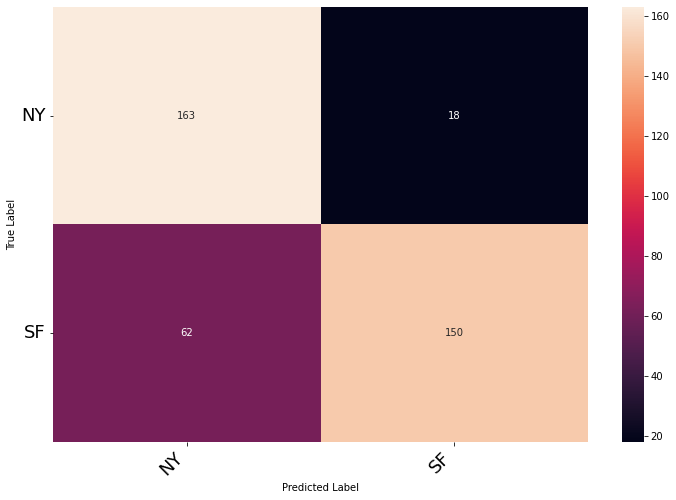

In [19]:
print_confusion_matrix(confusion_matrix(y_train, prediction_train), class_names=["NY","SF"])

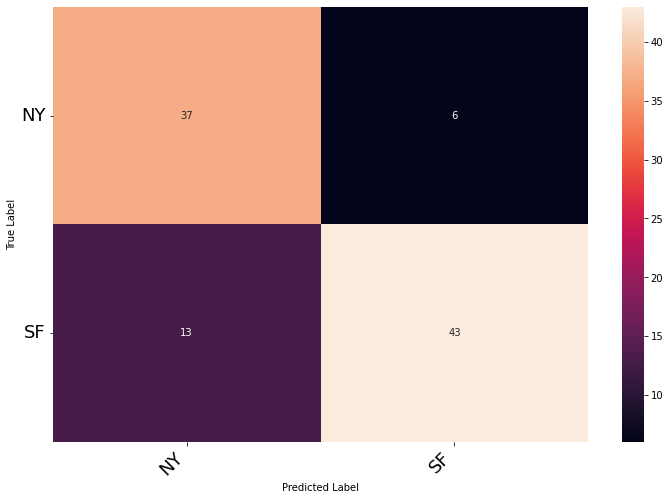

In [20]:
print_confusion_matrix(confusion_matrix(y_test, prediction_test), class_names=["NY","SF"])

| | predict NY (0) | predict SF (1)|
|---|---|---|
| **is NY (0)** | 37 | 6|
| **is SF (1)** | 13 | 43 |

Bu tablo bana şunları söylüyor:

1. Elimizde toplam **43 tane NY'da** olan ev var, **56 tane ise SF'da** olan ev var.
2. NY'da olan 43 tane evin, **37 tanesini NY'da**, **6 tanesini ise SF'da** olarak tahmin etmişiz. (İlk hata miktarı)
3. SF'da olan 56 tane evin, **43 tanesini SF'da**, **13 tanesini ise NY'da** olarak tahmin etmişiz. (İkinci hata miktarı)
4. Sonuç olarak, toplamda **80 tane** evi **doğru**, **19 tane** evi ise **hatalı** tahmin etmişiz.

## 5. Modeli Geliştirmek

Şimdi `pairplot()` fonksiyonumuzdan elde ettiğimiz çıktıya geri dönelim ve bizim için önemli olacağını düşündüğümüz bir feature daha modele dahil edelim.

- İncelemeyi tamamladıktan sonra `price_per_sqft` sütunu da bize yardımcı olabilir gibi duruyor, o yüzden `price_per_sqft` ve `elevation` sütunlarımızı modelimize girdi olarak verelim ve çıkan sonuçlara bakalım.

> **HATIRLATMA:** Bu sefer modelimize 2 tane girdi sağlayacağımız için modelimizi eğitmeden önce scaling uygulamayı unutmuyoruz!

In [21]:
std_scale = StandardScaler()

X_train = train_df[['elevation', 'price_per_sqft']]
X_train_scaled = std_scale.fit_transform(X_train) # Eğitim veri seti için fit_transform

X_test = X_test[['elevation', 'price_per_sqft']]
X_test_scaled = std_scale.transform(X_test) # Test veri seti için transform

lm2 = LogisticRegression(solver='liblinear')
lm2.fit(X_train_scaled, y_train)

print("Training Accuracy:", round(lm2.score(X_train_scaled, y_train),3))
print("Testing Accuracy:", round(lm2.score(X_test_scaled, y_test),3))

Training Accuracy: 0.819
Testing Accuracy: 0.798


In [22]:
elevation = 23
price_sqft = 25

dff = pd.DataFrame({
    'elevation': [elevation],
    'price_per_sqft': [price_sqft]
})
dff

,elevation,price_per_sqft
0,23,25


In [23]:
lm2.predict(dff.values)

array([1])

In [24]:
from joblib import dump, load

dump(lm2, 'logreg_model.pkl')

['logreg_model.pkl']

In [25]:
model = load("logreg_model.pkl")

In [26]:
model

LogisticRegression(solver='liblinear')

In [27]:
model.predict(dff.values)

array([1])